# Clustering  : cas pratique 

Le but de ce cas pratique est de réviser l'ensemble des algorithmes que nous avons vu ensemble dernièrement.  

## Les données 
Les données auxquelles nous nous intéressons sont celles de l'absentéisme dans une entreprise brésilienne. Les données sont dans le fichier csv `Absenteeism_at_work.csv` et leur description dans le fichier word `Attribute information`.   

## Première analyse en CAH  
Nous nous intéressons tout d'abord à essayer de regrouper les raisons de l'absence en moins de catégories qu'actuellement. Pour cela, nous allons mener une classification ascendante hiérarchique sur les variables explicatives de raisons de l'absence que nous avons à disposition. Nous allons utiliser l'ensemble des variables à notre disposition __sauf l'absentéisme en heures et les raisons de l'absence__.  

- Importez les données. Dans une nouvelle table stockez les variables qui nous intéressent et transformez les variables catégoriques en `dummies`.  


In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

#pd.set_option('display.max_columns',100)
pd.options.display.max_columns = 40

In [51]:
#import des données
df = pd.read_csv('Absenteeism_at_work_AAA/Absenteeism_at_work.csv', sep=';')
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [52]:
# suppression des doublons
df.drop_duplicates(inplace=True)

In [53]:
# on garde les variables qui nous intéressent
df = df.drop(['ID', 'Reason for absence', 'Absenteeism time in hours'], axis=1)
df.head()

,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index
0,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30
1,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31
2,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31
3,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24
4,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30


In [54]:
# création des dummies
df = pd.get_dummies(df, columns=['Seasons', 'Month of absence', 'Day of the week', 'Education'])
df.head()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Seasons_1,Seasons_2,Seasons_3,Seasons_4,Month of absence_0,Month of absence_1,Month of absence_2,Month of absence_3,Month of absence_4,Month of absence_5,Month of absence_6,Month of absence_7,Month of absence_8,Month of absence_9,Month of absence_10,Month of absence_11,Month of absence_12,Day of the week_2,Day of the week_3,Day of the week_4,Day of the week_5,Day of the week_6,Education_1,Education_2,Education_3,Education_4
0,289,36,13,33,239.554,97,0,2,1,0,1,90,172,30,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,118,13,18,50,239.554,97,1,1,1,0,0,98,178,31,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,179,51,18,38,239.554,97,0,0,1,0,0,89,170,31,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,279,5,14,39,239.554,97,0,2,1,1,0,68,168,24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,289,36,13,33,239.554,97,0,2,1,0,1,90,172,30,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0


- Mettez l'ensemble des variables à la même échelle avec le `MinMaxScaler` de scikit learn, qui permet de mettre les variables continues à la même échelle que les `dummies`.

In [55]:
# MinMaxscaler ne modifie pas les dummies et permet de mettre les
# variables continues à la même échelle entre 0 et 1
sc = MinMaxScaler()
df = sc.fit_transform(df)

 
- Affichez le dendogramme d'une analyse CAH et justifiez un choix de nombre de classes.  


In [56]:
# On fait d'abord la matrice de liens : 
mat_lien = linkage(df, method='ward', metric='euclidean')
mat_lien

array([[   2.        ,   13.        ,    0.        ,    2.        ],
       [ 231.        ,  235.        ,    0.        ,    2.        ],
       [  14.        ,  706.        ,    0.        ,    3.        ],
       ...,
       [1398.        , 1404.        ,   18.9825566 ,  252.        ],
       [1402.        , 1408.        ,   19.02028151,  406.        ],
       [1407.        , 1409.        ,   20.80760702,  706.        ]])

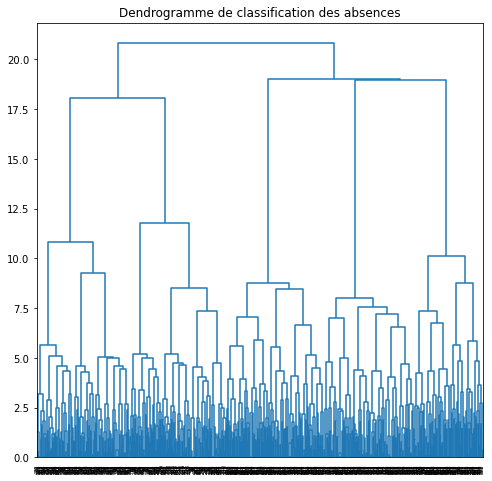

In [57]:
# Puis on peut afficher notre dendogramme : 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Dendrogramme de classification des absences")
dendrogram(mat_lien, orientation='top', color_threshold=0);

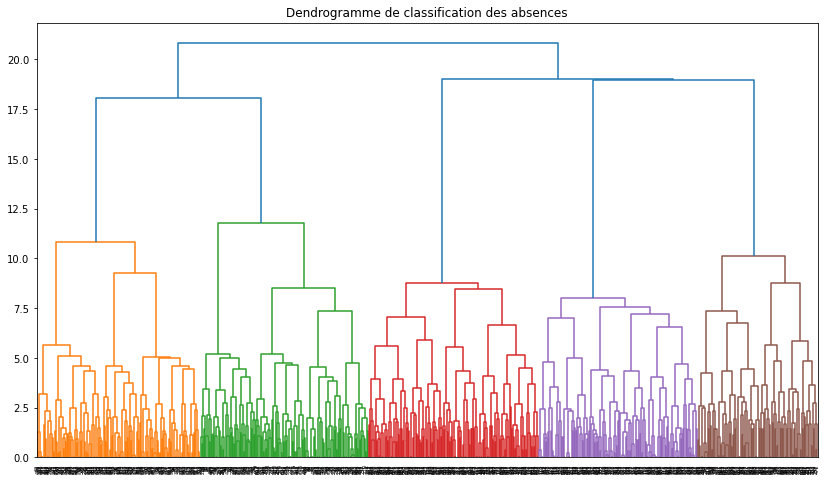

In [61]:
# On peut choisir 5 classes
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Dendrogramme de classification des absences")
dendrogram(mat_lien, orientation='top', color_threshold=12.5);

- Procédez à la classification de vos données en fonction de ce nombre de classes.

  - Affichez le tableau croisé des occurences des raisons pour l'absence et de vos classes obtenues. Y-a-t-il matière à faire un regroupement?

## Réduction du nombre de dimensions du problème  : Analyse en Composantes Principales  

Nous allons maintenant tenter de mettre en oeuvre une ACP.  

- En affichant le graphique de l'évolution du ratio de la variance expliquée en fonction du nombre de composantes, justifiez du choix d'un nombre de composantes.  

- Représentez graphiquement les points en fonction des deux premières composantes en colorant différemment selon la raison de l'absence. Trouve-t-on des regroupements qui coïncideraient avec les conclusions de la CAH?  Quel est le ratio de la variance expliqué par ces deux axes?  

## K-means et DBSCAN  
- Transformez les observations en fonction du nombre de composantes principales voulues en utilisant d'abord un algorithme de k-means puis un DBSCAN. 

- Comparez les résultats obtenus entre eux et avec la CAH.  

- Refaites ces classifications k-means et DBSCAN avec cette fois l'ensemble des variables explicatives à disposition. 

## Explication du temps d'absence   
On cherche maintenant à caractériser la longueur de l'absence, indépendemment de son motif.
- En reprenant l'analyse précédemment faite, regardez si le clustering peut aussi s'appliquer à la longueur de l'absence (absenteism in hours). Pour cela, regroupez cette variable en quelques classes que vous choisirez (pas d'absence - absence peu longue - absence longue - absence très longue). Pour déterminer les seuils qui discriminent le mieux les absences, vous pouvez utiliser une représentation graphique en fonction des deux premières composantes principales pour voir quelles nombres d'heures d'absence se trouvent aux mêmes endroits.
